In [1]:
import gym
# import pybulletgym.envs
import pybulletgym  # register PyBullet enviroments with open ai gym
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal

np.set_printoptions(suppress=True, precision=4)

In [2]:
class Policy(nn.Module):

    def __init__(self, num_classes, lr):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.tanh = nn.Tanh()
        
        self.sigma0 = nn.Parameter(torch.tensor([0.1]))
        self.sigma1 = nn.Parameter(torch.tensor([0.1]))
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.tanh(x)
        
        sigma0 = torch.relu(self.sigma0)
        sigma1 = torch.relu(self.sigma1)
        
        if self.sigma0 <= 0.001:
            sigma0 = sigma0 + 0.001
        
        if self.sigma1 <= 0.001:
            sigma1 = sigma1 + 0.001
        
        return x, sigma0, sigma1

def makePolicyNN(num_actions=2, lr=0.01):
    ''' Initialize the policy class '''
    assert isinstance(num_actions, int) and num_actions>0
    
    return Policy(num_actions, lr)

In [3]:
class PolicyGradient:
    def __init__(self, gamma, N=500, max_steps=1000):
        ''' Initialize the Reacher PyBullet environment '''
        assert isinstance(gamma, float) and 0.0<gamma<1.0, 'Invalid gamma'
        assert isinstance(N, int) and N>0
        assert isinstance(max_steps, int) and max_steps>0
        
        self.env = gym.make("modified_gym_env:ReacherPyBulletEnv-v1", rand_init=False)
        self.gamma = gamma
        self.N = N
        self.max_steps = max_steps
        self.numActions = 2
        self.numObs = 8
        self.num_steps = 0
        self.max_steps_reached = False
    
    def getAction(self, policy_network, state):
        ''' Return an action from a stochastic policy '''
        assert isinstance(state, np.ndarray) and len(state) == self.numObs
        
        state = torch.from_numpy(state).float()
        torque_mean, sigma0, sigma1 = policy_network(state) #forward pass
        
        # Defining diagonal elements of cov matrix 
        torque_cov = torch.eye(2)
        torque_cov[0,0], torque_cov[1,1] = sigma0, sigma1
        
        # Sampling from the 2D Gaussian and calculating the actions log probability
        m = MultivariateNormal(torque_mean, torque_cov)
        action = m.sample() #type tensor
        log_prob_of_action = m.log_prob(action) #type tensor

        return action, log_prob_of_action
    
    def runEpisode(self, policy_network):
        ''' Generate [s_t, a_t, r_t] pairs for one episode '''
        
        state = self.env.reset()
        done = False
        rewards, log_prob_of_actions = [], []
        while not(done):
            a, lpa = self.getAction(policy_network, state)
            state, r, done, info = self.env.step(np.array(a))
            r = rewards.append(r)
            log_prob_of_actions.append(lpa)
            self.num_steps += 1 #incrementing total number of steps in one iteration
            if self.num_steps >= self.max_steps: #checking
                self.max_steps_reached = True
                break;
        
        return rewards, log_prob_of_actions
    
    def doReinforcePart1(self, policy_network, verbose=False):
        ''' Improve policy by implementing vanilla version of Reinforce algo '''
        
        gamma = self.gamma
        arr_objective = []
        avg_returns = np.zeros((self.N,))
        num_episodes = np.zeros((self.N,))
        
        for i in range(self.N): #improving policy for "self.N" number of iterations
            n, objective = 0, 0
            
            # Resetting variables
            self.num_steps = 0
            self.max_steps_reached = False
            
            # Looping until a maximum number of steps are taken
            while not(self.max_steps_reached):
                # Run an episode with policy and count number of steps taken
                r, log_prob_of_actions = self.runEpisode(policy_network)
                n += 1 #increasing the episode count by 1
                
                # Calculate discounted return (G_tau) and summation of log probs of actions from the episode
                G_tau = sum([ r[t] * gamma**t for t in range(len(r))])
                sum_lpa = sum(log_prob_of_actions)
                avg_returns[i] += sum(r)
                
                # Calculate objective
                objective += G_tau * sum_lpa
                assert isinstance(objective, torch.Tensor)
            
            avg_returns[i] /= n
            num_episodes[i] = n
            # Updating policy
            policy_network.optimizer.zero_grad()
            objective = -objective/n #averaging objective over n episodes and flipping sign so it does gradient ascent
            objective.backward()
            policy_network.optimizer.step()
            arr_objective.append(objective.item())

            if verbose and (i%20 == 0):
                print('Iteration: {0} \t Objective: {1:.3f} \t Average reward: {2:.3f} \t Num_episodes: {3}'\
                      .format(i, objective, avg_returns[i], num_episodes[i]))

        return policy_network, arr_objective, avg_returns, num_episodes

current_dir=/Users/adnanshahpurwala/anaconda3/envs/ece276c_venv/lib/python3.6/site-packages/pybullet_envs/bullet
options= 
Iteration: 0 	 Objective: -100.465 	 Average reward: -22.730 	 Num_episodes: 1.0
Iteration: 20 	 Objective: -91.793 	 Average reward: -27.306 	 Num_episodes: 1.0


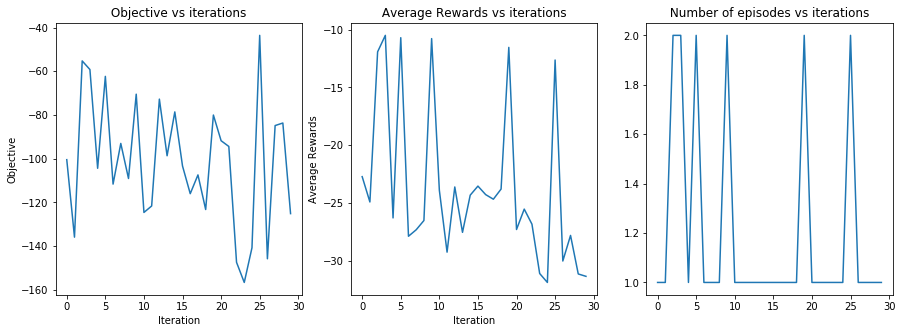

In [4]:
if __name__ == '__main__':
    torch.manual_seed(1)
    render_env = True
    plot = True
    
    policy_network = makePolicyNN(num_actions=2, lr=1e-3)
    pg = PolicyGradient(gamma=0.9, N = 30, max_steps=100)
    policy_network, arr_objective, avg_returns, num_episodes = pg.doReinforcePart1(policy_network, verbose=True)
    
    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(15,5))
        axs = axs.flatten()
        axs[0].plot(arr_objective)
        axs[0].set_xlabel('Iteration')
        axs[0].set_ylabel('Objective')
        axs[0].set_title(' Objective vs iterations ')
        axs[1].plot(avg_returns)
        axs[1].set_xlabel('Iteration')
        axs[1].set_ylabel('Average Rewards')
        axs[1].set_title(' Average Rewards vs iterations ')
        axs[2].plot(num_episodes)
        axs[2].set_title(' Number of episodes vs iterations ')
        plt.show()
    
    if render_env:
        steps = 0
        state = pg.env.reset()
        done = False
        while steps<300:
            a, _ = pg.getAction(policy_network, state)
            state, r, done, info = pg.env.step(np.array(a))
            steps+=1
            pg.env.render()
        pg.env.env.close()